In [18]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.cluster import KMeans

# EDA

In [2]:
# Подгружаю данные из файла
data_path = 'table.csv'
data = pd.read_csv(data_path)

data.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
c_data = data.copy()
c_data.drop(columns=['id', 'lon', 'lat'], axis=1, inplace=True)

In [3]:
print("--- Информация о данных ---")
data.info()
print("\n--- Основные статистики рейтинга и количества отзывов ---")
print(c_data.describe())

--- Информация о данных ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0.1  1565 non-null   int64  
 1   id            1565 non-null   int64  
 2   adress        1565 non-null   object 
 3   name          1565 non-null   object 
 4   lat           1565 non-null   float64
 5   lon           1565 non-null   float64
 6   rating        1565 non-null   float64
 7   review_count  1565 non-null   int64  
 8   city          1565 non-null   object 
dtypes: float64(3), int64(3), object(3)
memory usage: 110.2+ KB

--- Основные статистики рейтинга и количества отзывов ---
       Unnamed: 0.1       rating  review_count
count     1565.0000  1565.000000   1565.000000
mean       782.0000     4.290096    354.978914
std        451.9209     0.673207   1596.718027
min          0.0000     1.000000      1.000000
25%        391.0000     4.000000   

In [4]:
# Проверю на пропуски
print("--- Пропуски в данных ---")
print(data.isnull().sum())

--- Пропуски в данных ---
Unnamed: 0.1    0
id              0
adress          0
name            0
lat             0
lon             0
rating          0
review_count    0
city            0
dtype: int64


--- Визуализация распределений числовых признаков ---


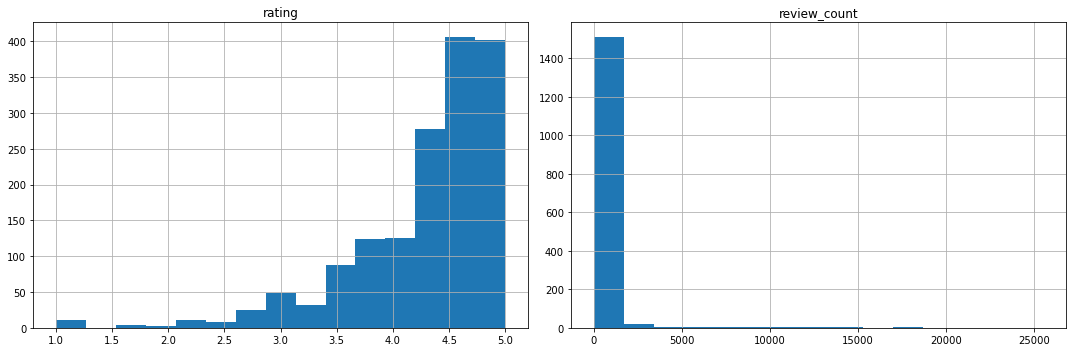

In [5]:
# Смотрю на распределения числовых признаков
print("--- Визуализация распределений числовых признаков ---")
num_cols = data.select_dtypes(include=['float64', 'int64']).columns
interesting_num_cols = ['rating', 'review_count']
data[interesting_num_cols].hist(bins=15, figsize=(15, 5), layout=(len(interesting_num_cols) // 3 + 1, 2))
plt.tight_layout()
plt.show()

--- Матрица корреляции ---


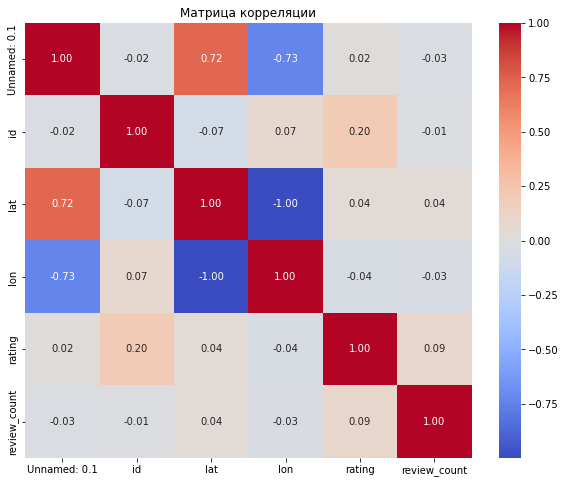

In [6]:
# Корреляция между числовыми признаками
print("--- Матрица корреляции ---")
plt.figure(figsize=(10, 8))
corr_matrix = data[num_cols].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Матрица корреляции")
plt.show()

In [7]:
# Вывод уникальных значений для категориальных признаков
cat_cols = data.select_dtypes(include=['object']).columns
if len(cat_cols) > 0:
    print("--- Уникальные значения для категориальных признаков ---")
    for col in cat_cols:
        print(f"{col}: {data[col].nunique()} уникальных значений")

--- Уникальные значения для категориальных признаков ---
adress: 1380 уникальных значений
name: 1327 уникальных значений
city: 2 уникальных значений


--- Распределения и выбросы для числовых признаков ---


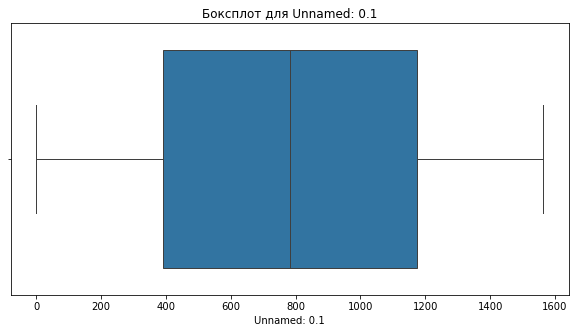

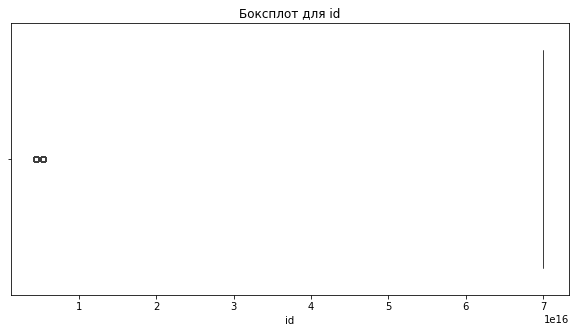

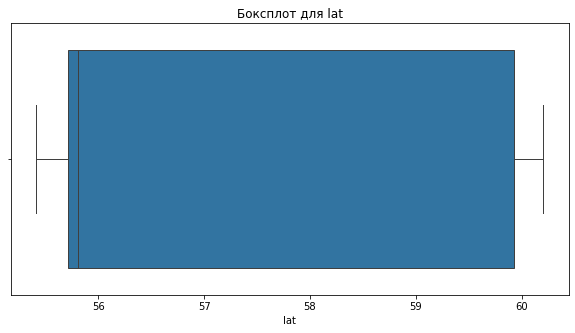

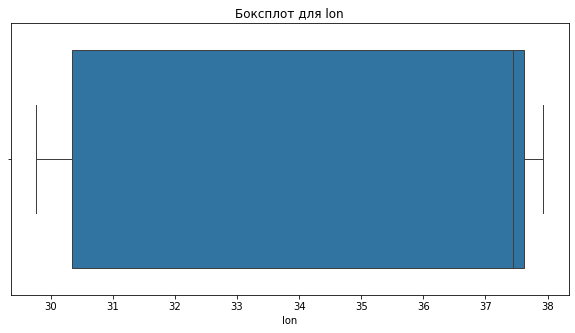

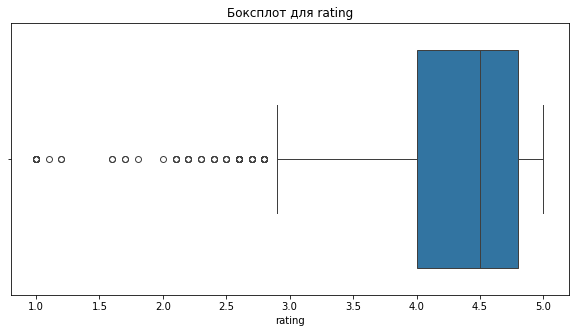

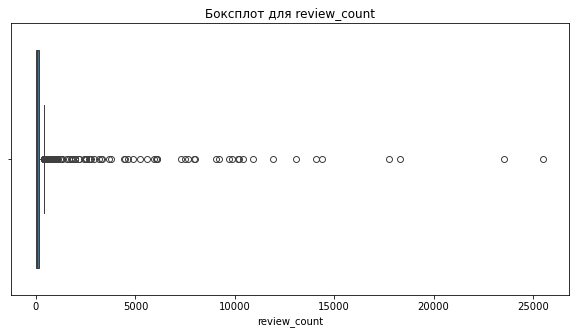

In [8]:
# Распределения и выбросы числовых признаков
print("--- Распределения и выбросы для числовых признаков ---")
for col in num_cols:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=data[col])
    plt.title(f"Боксплот для {col}")
    plt.show()

--- Визуализация графа ---


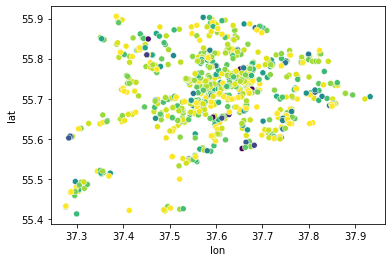

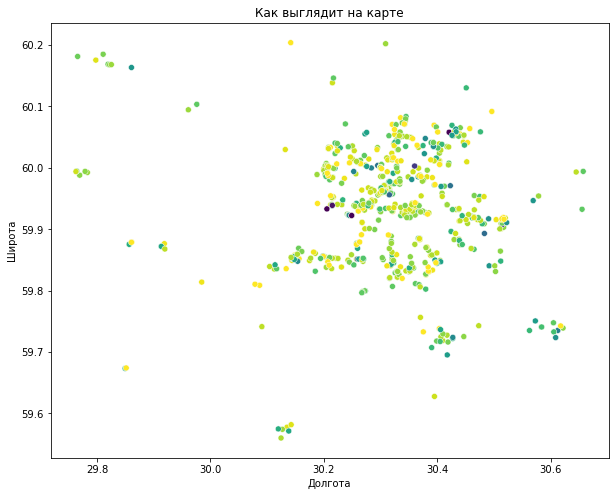

In [17]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

print("--- Визуализация графа ---")
plt.figure(figsize=(10, 8))

plt.figure(0)
sns.scatterplot(
    x='lon',
    y='lat',
    data=data[data['city'] == 'msk'],
    hue=data.loc[data['city'] == 'msk', 'rating'],
    palette="viridis",
    legend=None
)

plt.figure(1)
sns.scatterplot(
    x='lon',
    y='lat',
    data=data[data['city'] == 'spb'],
    hue=data.loc[data['city'] == 'spb', 'rating'],
    palette="viridis",
    legend=None
)

plt.title("Как выглядит на карте")
plt.xlabel("Долгота")
plt.ylabel("Широта")
plt.show()

--- Визуализация графа ---


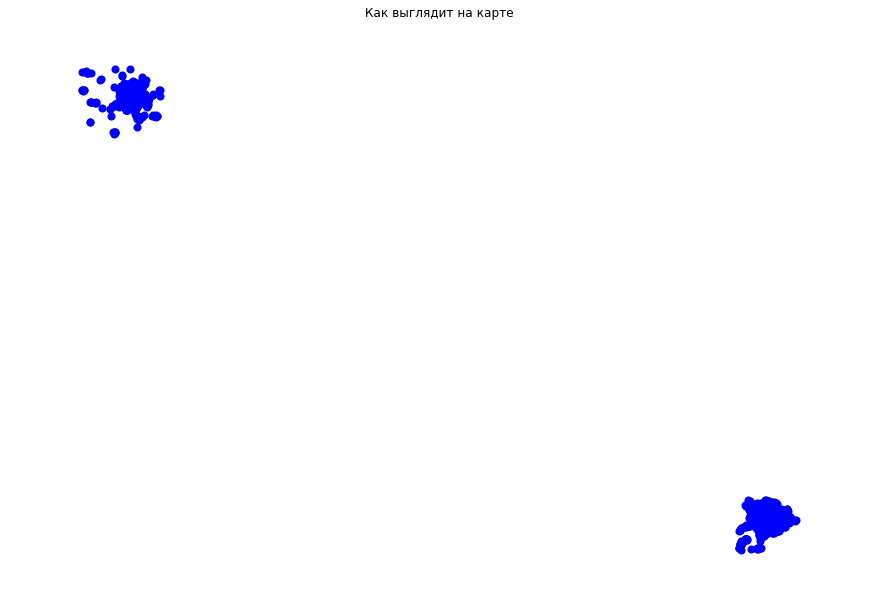

In [10]:
# Построение графа с помощью networkx
print("--- Визуализация графа ---")
graph = nx.Graph()

for _, row in data.iterrows():
    graph.add_node((row['lon'], row['lat']))

nodes = list(graph.nodes)
for i in range(len(nodes)):
    for j in range(i + 1, len(nodes)):
        lon1, lat1 = nodes[i]
        lon2, lat2 = nodes[j]
        distance = haversine(lat1, lon1, lat2, lon2)
        if distance <= 1.0:  # Ограничение на расстояние 1 км (просто хочу)
            graph.add_edge(nodes[i], nodes[j])

plt.figure(figsize=(12, 8))
pos = {node: node for node in graph.nodes}
nx.draw(graph, pos, with_labels=False, node_size=50, node_color='blue', edge_color='gray')
plt.title("Как выглядит на карте")
plt.show()

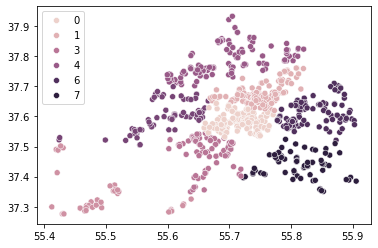

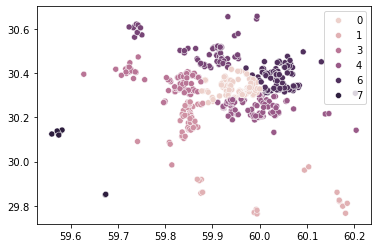

In [22]:
msk = data.loc[data['city'] == 'msk']
data_msk = np.array([[lat, lon] for lat, lon in zip(msk['lat'].iloc, msk['lon'].iloc)])

spb = data.loc[data['city'] == 'spb']
data_spb = np.array([[lat, lon] for lat, lon in zip(spb['lat'].iloc, spb['lon'].iloc)])

cluster_num = 8

clustering_msk = KMeans(n_clusters=cluster_num).fit(data_msk)
clustering_spb = KMeans(n_clusters=cluster_num).fit(data_spb)

plt.figure(0)
sns.scatterplot(x=data_msk[:, 0], y=data_msk[:, 1], hue=clustering_msk.labels_)
plt.figure(1)
sns.scatterplot(x=data_spb[:, 0], y=data_spb[:, 1], hue=clustering_spb.labels_)
plt.show()